# This Notebook goes through how to use QuasarModelFunctions in order to produce light curves

Start with imports

In [1]:
import numpy as np
import numpy.random as random
import QuasarModelFunctions as QMF
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.nddata import block_reduce
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from scipy.fft import fft, fftfreq, ifft
from scipy import signal
from scipy.interpolate import UnivariateSpline
%matplotlib inline
import glob


Not all imports are needed for every task, but they always look nicer when imported together at the top

# Opening an accretion disk file from Gyoto

In [2]:
fdir = '/Users/henrybest/PythonStuff/DiskImages/DataSetBand300Res/' #Disk was created at 300x300 resolution
fname = 'ImageFilelog8.00.1510gband300res.disk' #Naming method: "ImageFilelog"+mass exponent+eddington ratio+inclination angle+filter+resolution+".disk"

gyotodisk = QMF.LoadDiskImage(fdir+fname, 300) # When these images were prepared, I did not save them as fits files. Then I had too many to comfortably convert them all when I wanted to...



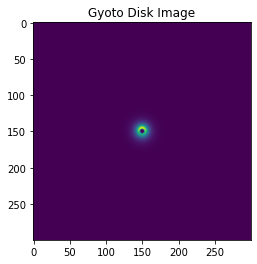

In [3]:
figdisk, axdisk = plt.subplots()
axdisk.set_title("Gyoto Disk Image")
axdisk.imshow(gyotodisk)


Or, sometimes I plot the log image to accentuate how far out the data goes

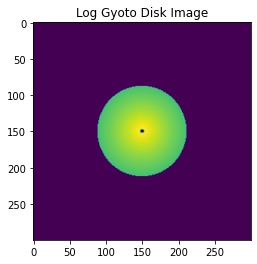

In [4]:
figdisk2, axdisk2 = plt.subplots()
axdisk2.set_title("Log Gyoto Disk Image")
axdisk2.imshow(np.log(1+gyotodisk))  # I add 1 so NaN's dont exist...

These images only have mass of $10^{8.0} M_{\odot}$. This is why they look small. With All Gyoto images I've produced, I applied a field of view (fov) of 0.12 radians. The camera's distance is at a position 4000 $R_{g}$. These values are important in calculating pixel size for convolutions!

# Opening a Sim5 Accretion Disk

This is much simpler, since they're saved as fits files. Therefore, no need for running the custom function to open the .disk files of Gyoto, or even needing to know the resolution beforehand.

In [5]:
fdir = '/Users/henrybest/PythonStuff/DiskImages/Sim5Disks/'
fname = 'Sim5ThinDisk8.0Msun0.1Spin40Inc.fits' #Naming method: "Sim5ThinDisk"+mass+spin+inclination angle+".fits"
with fits.open(fdir+fname) as f:
    sim5disk = f[0].data

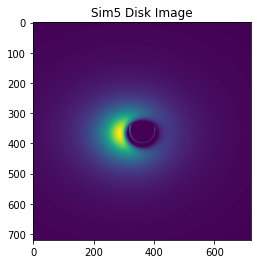

In [6]:
figdisk3, axdisk3 = plt.subplots()
axdisk3.set_title("Sim5 Disk Image")
axdisk3.imshow(sim5disk)

Keep in mind these disks are created with different scales! Sim5 allows for much faster disk creation, so I used a higher resolution. The images themselves are all created out to 50 $R_{g}$ in each direction, so each side is 100 x 100 $R_{g}$ (as opposed to a fixed field of view). I chose resolution of 720 because this is 6!, allowing for good block reduction in the convolution process.

# Making a Microlensing Light Curve

So now, let's use these disk images to create a microlensing light curve. Load the disk and the magnification maps. 

In [7]:
mapdir = '/Users/henrybest/PythonStuff/LensingMaps/SampleMagMaps/map_1/'
mapfname = 'map.fits'
with fits.open(mapdir+mapfname) as f:
    MagMap2d = f[0].data
    

Since Gyoto disks and Sim5 disks have different parameters, we must do the convolutions slightly different. In the spirit of how we loaded the disks, we will start with Gyoto and then proceed to Sim5.

In [8]:
## Parameters for convolution
m_bh_exp = 8.0 #black hole mass exponent
zlens = 0.6 #lens redshift
zquasar = 2.1 #source redshift
mlens = (1.0)*const.M_sun.to(u.kg)  #microlens mass

fov = 0.12    # Same for most Gyoto Images I've created
cam_dist = 4000
disk_res = 300

map_ER = 25  # Same for most Gerlumph maps. If default, QMF.ConvolveMap doesn't need to be passed them.
map_px = 10000  # If changed, please pass in keywords with values

## Calculations
convo_gyoto, smooth_convo_gyoto, pxsize_gyoto = QMF.ConvolveMap(MagMap2d, gyotodisk, zlens = zlens, 
                zquasar = zquasar, mquasarexponent = m_bh_exp, mlens = mlens, verbose=True)


Magnification Map Opened. Shape = (10000, 10000)
Disk Opened. Shape = (300, 300)
A pixel on the mag map is 1194147295842.2693 m
A pixel on the disk map is 236260006088.01996 m
The disk's shape is now: (59, 59)
Convolution Completed


With the convolution done, we can simply extract however many light curves as we'd like from it. I have 2 methods: PullLightCurve and PullRandLC. PullLightCurve extracts a specific track, while PullRandLC pulls a random one. You can also extract the track if desired, particularly for comparing disks following the same convolution.

In [9]:
velocity = 700 #km/s
time = 10 #years
ncurves = 10

In [10]:
gyotolcs = []
gyototracks = []
print(smooth_convo_gyoto(500, 202))
for jj in range(ncurves):
    lc, track = QMF.PullRandLC(convo_gyoto.real, pxsize_gyoto, 
                    velocity, time, returntrack=True, bivarspline=smooth_convo_gyoto) 
    # I take the real part of the convolution to supress warnings (convolutions become "complex", but with all complex values = 0).
    gyotolcs.append(lc)
    gyototracks.append(track)

[[4.34414073e+19]]


In [11]:
print(np.shape(gyotolcs))

(10, 185)


And just like that, we have 10 randomly generated light curves. They aren't perfect, but let's look at them anyway:

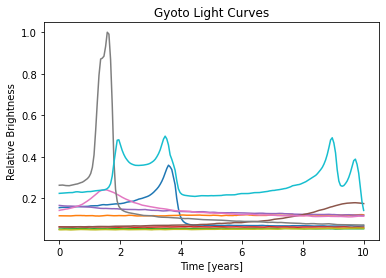

In [12]:
figgyotolcs, axgyotolcs =plt.subplots()
axgyotolcs.set_title("Gyoto Light Curves")
axgyotolcs.set_xlabel("Time [years]")
axgyotolcs.set_ylabel("Relative Brightness")

for jj in range(ncurves):
    t = np.linspace(0, time, np.size(gyotolcs[jj], 0))
    axgyotolcs.plot(t, gyotolcs[jj]/np.max(gyotolcs))
    
    

I'm sure there are some noisy looking curves sitting at the top, and this is just an artifact of the disk not crossing a high magnification region. Normalization throws them up top, and interpolation between pixels leads to jittering. 

This is suppressed for any interesting microlensing light curves, such as those with high amplitude changes.

I also returned the tracks, which are tuples as shown below

In [13]:
print(np.shape(gyototracks))

(10, 2, 185)


The shape is odd, but it is of form (light curve number, direction, timestep). light curve number is the corresponding light curve. direction is 0 for x, 1 for y. timestep is where along the light curve we are. The output is then the pixel index on the convolution map. 

Using these, we can compare various disks using identical tracks, as such...

In [14]:
fdir = '/Users/henrybest/PythonStuff/DiskImages/DataSetBand300Res/' 
fname2 = 'ImageFilelog8.00.1545gband300res.disk' 

gyotodisk2 = QMF.LoadDiskImage(fdir+fname2, 300)
convo_gyoto2, smooth_convo_gyoto2, pxsize_gyoto2 = QMF.ConvolveMap(MagMap2d, gyotodisk2, zlens = zlens, 
                zquasar = zquasar, mquasarexponent = m_bh_exp, mlens = mlens, verbose=True)


Magnification Map Opened. Shape = (10000, 10000)
Disk Opened. Shape = (300, 300)
A pixel on the mag map is 1194147295842.2693 m
A pixel on the disk map is 236260006088.01996 m
The disk's shape is now: (59, 59)
Convolution Completed


In [15]:
gyoto_alt_lcs = []

for jj in range(ncurves):
    lc = smooth_convo_gyoto2(gyototracks[jj][0], gyototracks[jj][1], grid=False) # we can just plug the tracks into the convolution
    gyoto_alt_lcs.append(lc)

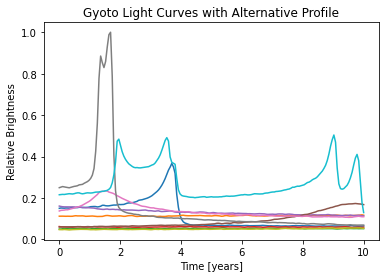

In [16]:
figgyotolcs2, axgyotolcs2 =plt.subplots()
axgyotolcs2.set_title("Gyoto Light Curves with Alternative Profile")
axgyotolcs2.set_xlabel("Time [years]")
axgyotolcs2.set_ylabel("Relative Brightness")

for jj in range(ncurves):
    t = np.linspace(0, time, np.size(gyoto_alt_lcs[jj], 0))
    axgyotolcs2.plot(t, gyoto_alt_lcs[jj]/np.max(gyoto_alt_lcs))
    

## Now for creating the Sim5 Convolutions

In [17]:
convo_sim5, smooth_convo_sim5, pxsize_sim5 = QMF.ConvolveSim5Map(MagMap2d, sim5disk, 
                                    zlens = zlens, 
                                    zquasar = zquasar, mquasarexponent = m_bh_exp, 
                                    mlens = mlens, verbose=True)

Magnification Map Opened. Shape = (10000, 10000)
Disk Opened. Size = (720, 720)
A pixel on the mag map is 1194147295842.2693 m
A pixel on the disk map is 20508681084.02951 m
The disk's shape is now: (12, 12)
Convolution Completed


In [18]:
sim5lcs = []
sim5tracks = []
for jj in range(ncurves):
    lc, track = QMF.PullRandLC(convo_sim5.real, pxsize_sim5, velocity, time, 
                               bivarspline=smooth_convo_sim5, returntrack=True)
    sim5lcs.append(lc)
    sim5tracks.append(track)

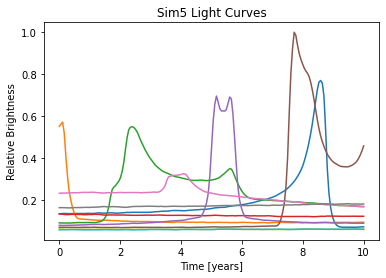

In [19]:
figsim5lcs, axsim5lcs = plt.subplots()
axsim5lcs.set_title("Sim5 Light Curves")
axsim5lcs.set_xlabel("Time [years]")
axsim5lcs.set_ylabel("Relative Brightness")

for jj in range(ncurves):
    t = np.linspace(0, time, np.size(sim5lcs[jj], 0))
    axsim5lcs.plot(t, sim5lcs[jj]/np.max(sim5lcs))
    
    

In [20]:
Map = "/Users/henrybest/PythonStuff/LensingMaps/image_2237_b_zoom2.dat"
with open(Map, 'rb') as f:
    MagMap = np.fromfile(f, 'i', count = -1, sep=' ')

In [21]:
XYMap = QMF.ConvertMagMap(MagMap)

In [22]:
hrconvo_sim5, smooth_hrconvo_sim5, pxsize_hrsim5 = QMF.ConvolveSim5Map(XYMap, sim5disk, 
                                    zlens = zlens, nmapERs = 1, rotation=90,
                                    zquasar = zquasar, mquasarexponent = m_bh_exp, 
                                    mlens = mlens, verbose=True)

Magnification Map Opened. Shape = (10000, 10000)
Disk Opened. Size = (720, 720)
Disk Rotated
A pixel on the mag map is 47765891833.690765 m
A pixel on the disk map is 20508681084.02951 m
The disk's shape is now: (309, 309)
Convolution Completed


In [23]:
hrsim5lcs = []
hrsim5tracks = []
time=7
for jj in range(ncurves):
    lc, track = QMF.PullRandLC(hrconvo_sim5.real, pxsize_hrsim5, velocity, time, 
                               bivarspline=smooth_hrconvo_sim5, returntrack=True)
    hrsim5lcs.append(lc)
    hrsim5tracks.append(track)

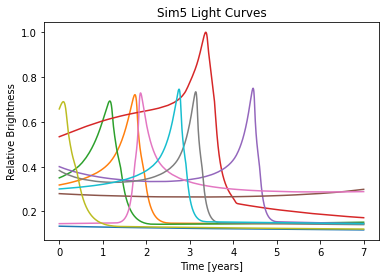

In [24]:
fighrsim5lcs, axhrsim5lcs = plt.subplots()
axhrsim5lcs.set_title("Sim5 Light Curves")
axhrsim5lcs.set_xlabel("Time [years]")
axhrsim5lcs.set_ylabel("Relative Brightness")

for jj in range(ncurves):
    t = np.linspace(0, time, np.size(hrsim5lcs[jj], 0))
    axhrsim5lcs.plot(t, hrsim5lcs[jj]/np.max(hrsim5lcs))
    
    

In [25]:
ploom = fits.PrimaryHDU(XYMap)
ploom.writeto('image_2237_b_zoom2.fits')

And there we have some microlensing light curves!

Next, let's take a look at adding a BELR object.

# Creating a BELR

The way I have BELR implimented, it must be bound by streamlines. We will start off creating one by defining their properties.

In [26]:
# Streamline Parameters
zmax = 1e15 * u.m #Max height of the BELR
theta_in = 20 #Degrees, inner streamline bound
theta_out = 60 #Degrees, outer streamline bound
belrfunction = 2 #A switch statement. 1 = power law, 2 = gaussian, 3 = tophat
r0 = 7e14 * u.m #Central location of emission region if gaussian, or start position if tophat. Implicit units m
sigma = 2e14 * u.m #Width of emitting region. Implicit units m
r_launch_in = 1e13 * u.m #Inner streamline launch position
r_launch_out = 3e13 * u.m #Outer streamline launch position
zslices = 100 # Number of slices to create in the z-direction
maxvel = 1e7 * u.m/u.s # Maximum poloidal velocity accelerated to. Implicit units m/s.
v_scaleheight = 1e14 * u.m # Scale Distance for velocity acceleration. Implicit units m.
v_alpha = 1 # Acceleration parameter

In [27]:
SLin = QMF.CreateWindLine(r_launch_in, theta_in, zmax, zslices, v_scaleheight, 
                          maxvel = maxvel, alpha=v_alpha) #Inner Streamline
SLout = QMF.CreateWindLine(r_launch_out, theta_out, zmax, zslices, v_scaleheight, 
                           maxvel = maxvel, alpha=v_alpha) #Outer Sreamline

BELR, rlen, zlen, philen, rmin = QMF.CreateWindRegion(SLin, SLout, phi_res=80, 
                            function=belrfunction, r0 = r0, sigma = sigma)

We now have a model for the BELR. Let's project it onto the plane of the accretion disk.

Doing this projection takes quite a bit of time...

In [22]:
inc_ang = 70
xres = 200
velocities = [0] #This is a filler for LoS velocities. Only implimented in reverberation calculation..
screen, fov_BELR = QMF. ProjectWind(BELR, rlen, zlen, philen, rmin, inc_ang, xres, SLin, SLout, 
                    velocities, geounits = 4000, mass = 10**(m_bh_exp) * const.M_sun.to(u.kg))

5.966480190176292


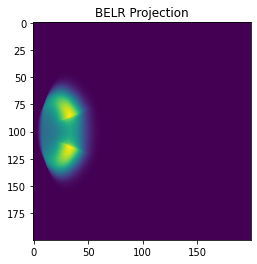

In [23]:
figBELR, axBELR = plt.subplots()
axBELR.set_title("BELR Projection")
axBELR.imshow(screen)
print(fov_BELR) #Do not worry about large fov here. 
# It is an artifact of inverting the small angle approx, 
# so even large fov (even those greater than pi!) can later use this approx without issues.


There we have it. A projection of the BELR in the plane of the accretion disk, with everything needed to do some microlensing of it (even if the effect is minimal due to the large size of the BELR compared to the accretion disk).

**Note that we use geounits and mass and fov, like Gyoto images. I need to work on getting this to work nicely with Sim5 parameters sometime.**


In [24]:
print(np.shape(MagMap2d))
convo_BELR, smooth_convo_BELR, pxsize_BELR = QMF.ConvolveMap(MagMap2d, screen, diskres = xres, zlens=zlens, 
                                         zquasar=zquasar, mquasarexponent=m_bh_exp, mlens=mlens,
                                         diskfov = fov_BELR, verbose=True)


(10000, 10000)
Magnification Map Opened. Size = (10000, 10000)
Disk Opened. Size = (200, 200)
A pixel on the mag map is 1194147295842.2693 m
A pixel on the disk map is 17620508075688.766 m
Magnification Map Changed. Size = (666, 666)
Convolution Completed


In [25]:
BELRlcs = []
for jj in range(ncurves):
    lc = QMF.PullRandLC(convo_BELR, pxsize_BELR, velocity, time, 
                        bivarspline=smooth_convo_BELR)
    BELRlcs.append(lc)

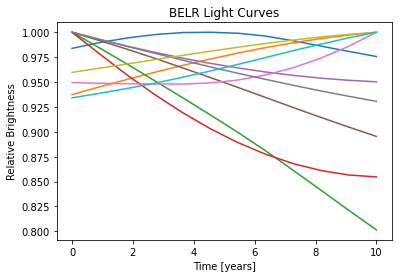

In [26]:
figBELRlcs, axBELRlcs = plt.subplots()
axBELRlcs.set_title("BELR Light Curves")
axBELRlcs.set_xlabel("Time [years]")
axBELRlcs.set_ylabel("Relative Brightness")

for jj in range(ncurves):
    t = np.linspace(0, time, np.size(BELRlcs[jj], 0))
    axBELRlcs.plot(t, BELRlcs[jj]/np.max(BELRlcs[jj]))

These light curves are pretty boring, due to the size of the BELR being much larger. 

# Creating a reverberating disk

Here I will show how to use the CreateReverbDisk function

In [44]:
steps = 300 # Number of time steps
incang = 10 # Needed to calculate time delays
steptimescale = 60*60 # 1 step = 1 light hour
flickering = QMF.DampedWalk(np.ones(steps), dampingfactor = 0.01)
hdu, _, _, _= QMF.CreateReverbDisk(gyotodisk, steps, incang, zquasar=zquasar, 
                    steptimescale = steptimescale, mass = 10**m_bh_exp*10**30, 
                    inputsignal = True, illumination = flickering)

CreateReverbDisk has 4 outputs. First, is the reverberating accretion disk which relates exactly to the input disk (here, gyotodisk). Second is a scaled accretion disk, where sizes are increased by a scale factor depending on wavelength. This is only an approximation, but it is enough to have different disk size outputs. Third output is the illumination, which is useful if you don't want to predefine the illuminating signal. Finally is the disk size ratio, which is the increase (or decrease) in the accretion disk size.

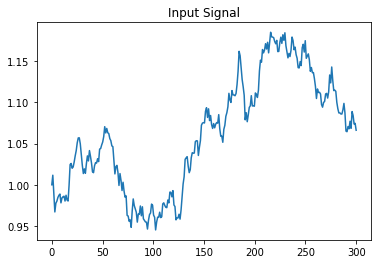

In [45]:
figsignal, axsignal = plt.subplots()
axsignal.set_title("Input Signal")
t = np.linspace(0, steps, steps)
axsignal.plot(t, flickering)

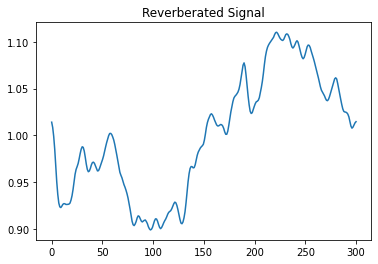

In [46]:
figreverbsignal, axreverbsignal = plt.subplots()
axreverbsignal.set_title("Reverberated Signal")
axreverbsignal.plot(t, np.sum(hdu, (0, 1))/np.average(np.sum(hdu, (0, 1))))

To understand the transfer function, we can create a time delay map and compress it:

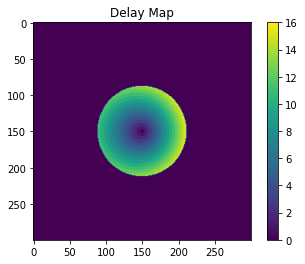

In [49]:
# WARNING: SOMETIMES THE DELAY MAP GLITCHES. IF YOU FIND LUDICROUS NUMBERS, RERUN THIS BLOCK A FEW TIMES.
delaymap = QMF.CreateTimeDelayMap(gyotodisk, incang, massquasar=10**m_bh_exp*const.M_sun.to(u.kg))

figdelay, axdelay = plt.subplots()
axdelay.set_title("Delay Map")
delayplot = axdelay.imshow(delaymap)
figdelay.colorbar(delayplot) #units light hours

In [50]:
transfer_function = np.zeros(np.max(delaymap))
for jj in range(np.max(delaymap)):
    maskin = delaymap>=jj
    maskout = delaymap<=(jj+1)
    mask = maskin * maskout
    transfer_function[jj] = np.sum((mask * gyotodisk), (0, 1))



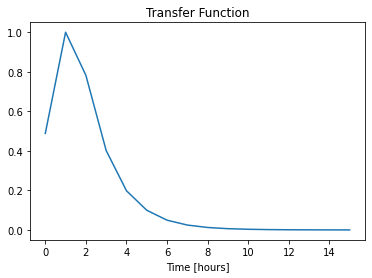

In [51]:
figtrans, axtrans = plt.subplots()
axtrans.set_title("Transfer Function")
axtrans.set_xlabel("Time [hours]")
axtrans.plot(transfer_function/np.max(transfer_function))

This is a function of inclination angle and mass. If we use a higher mass and different viewing angle...

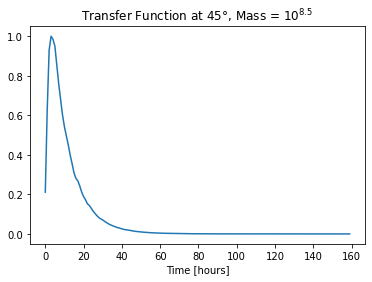

In [59]:
fdir = '/Users/henrybest/PythonStuff/DiskImages/DataSetBand300Res/' #Disk was created at 300x300 resolution
fname = 'ImageFilelog8.50.1545gband300res.disk' #Naming method: "ImageFilelog"+mass exponent+eddington ratio+inclination angle+filter+resolution+".disk"
incang2 = 45
m_bh_exp2 = 8.5
gyotodisk2 = QMF.LoadDiskImage(fdir+fname, 300) # When these images were prepared, I did not save them as fits files. Then I had too many to comfortably convert them all when I wanted to...

delaymap2 = QMF.CreateTimeDelayMap(gyotodisk2, incang2, massquasar=10**m_bh_exp2*const.M_sun.to(u.kg))

transfer_function2 = np.zeros(np.max(delaymap2))
for jj in range(np.max(delaymap2)):
    maskin2 = delaymap2>=jj
    maskout2 = delaymap2<=(jj+1)
    mask2 = maskin2 * maskout2
    transfer_function2[jj] = np.sum((mask2 * gyotodisk2), (0, 1))

figtrans2, axtrans2 = plt.subplots()
axtrans2.set_title("Transfer Function at 45$\degree$, Mass = $10^{8.5}$")
axtrans2.set_xlabel("Time [hours]")
axtrans2.plot(transfer_function2/np.max(transfer_function2))

Of course, these should be scaled based on how impactful the reverberation should appear

# Reverberation through BELR

Earlier, we created a wind region (or BELR), which will also reverberate according to the input signal. As a warning, this can take quite some time to propogate through the BELR object due to how many gridpoints it contains.

In [37]:
reverbBELR, wind, velocities = QMF.ReverberateWind(BELR, flickering, 
                        inc_ang, rlen, zlen, philen)
## If the illuminating signal is not long enough, my functions will loop through it. 
## To stop this, increase the signal length!
## By default, ReverberateWind has timescale set to 1 day per time unit

3 objects come out of ReverberateWind. First, reverbBELR is the light curve with no structural information saved. Second, wind is the reverberating object (which contains all the information spacially and in time). Additionally, it has a velocity index, which relates to the velocitites output. This allows for one region in velocity space to be selected (units beta, along line of sight). 

If you want some region selected for microlensing without reverberation, you can input an illuminating signal of [1], and then choose any time step. Finally, select the velocity selected region, and only use that slice.

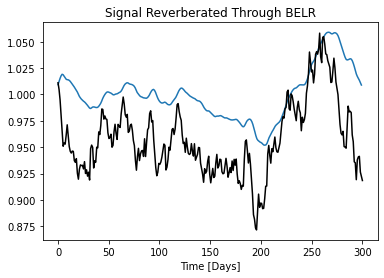

In [38]:
figBELRreverb, axBELRreverb = plt.subplots()
axBELRreverb.set_title("Signal Reverberated Through BELR")
axBELRreverb.set_xlabel("Time [Days]")
axBELRreverb.plot(reverbBELR/np.average(reverbBELR))
axBELRreverb.plot(t, flickering, c='black')



I have plans to write a function on creating the transfer function for these BELR objects, but it is not prepared at the moment. Unlike the reverb disk, I cannot make a projected delay map as each pixel is multi-valued. 

# Microlensing reverberating (or time dependent) disks

First, I would like to thank discussion with Georgios and the opportunity to work on Molet for this part. I implimented a similar method to get this working in Python (I still am unsure its status in Molet...), but this is a proof of concept regardless, showing that it works and no longer causes memory related crashes.

To show how it works, I am first making an image stack out of the two Gyoto disks loaded in memory already. I stack them along a third dimension, and feed into QMF.TimeDependentLCGenerator. I divide by their sum so they have relatively the same total brightness pre-microlensing.

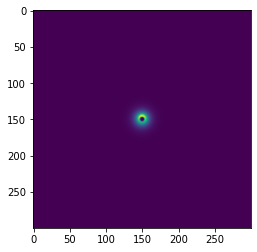

In [60]:
gyotodisk/=np.sum(gyotodisk)
plt.imshow(gyotodisk)

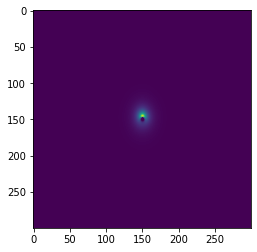

In [61]:
gyotodisk2/=np.sum(gyotodisk2)
plt.imshow(gyotodisk2)

In [62]:
diskstack = np.zeros((300, 300, 10))
diskstack[:, :, 0] = gyotodisk
diskstack[:, :, 1] = gyotodisk2
diskstack[:, :, 2] = gyotodisk2
diskstack[:, :, 3] = gyotodisk2
diskstack[:, :, 4] = gyotodisk
diskstack[:, :, 5] = gyotodisk
diskstack[:, :, 8] = gyotodisk2
diskstack[:, :, 9] = gyotodisk2
#Missing indexes 6 and 7 to prove zeros get inserted into time dependence properly

In [63]:
LCs, tracks = QMF.TimeDependentLCGenerator(MagMap2d, diskstack, ncurves, velocity, time, 
            zlens = 0.5, zquasar = 2.1, mquasarexponent = 8.0, mlens = 1.0*const.M_sun.to(u.kg),
            nmapERs = 25, numGRs = 100, diskfov = 0.12, diskposition = 4000, diskres = 300, 
                        sim5 = False, rotation=False, verbose=False)
# The sim5 toggle can be used to run the same process using the sim5 method. By default, 
# I pass in all values both methods require, just so crashes don't occur.


In [64]:
print(np.shape(LCs))

(10, 168)


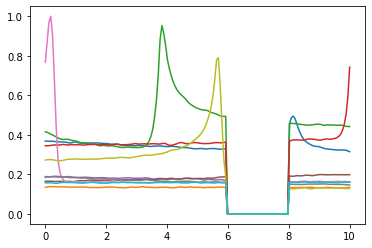

In [65]:
for jj in range(ncurves):
    t = np.linspace(0, time, np.size(LCs[jj], 0))
    plt.plot(t, LCs[jj]/np.max(LCs))

Now that the test appears to work, let's use our reverberating disk model that was previously created

In [66]:
print(np.shape(hdu))

(300, 300, 300)


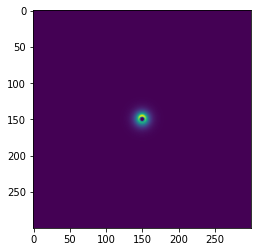

In [67]:
plt.imshow(hdu[:,:,130]*gyotodisk)

Each time slice adds another convolution required to complete the light curves, so I am only taking the first 50 time steps for this demonstration. It still takes quite some time!

I am approximating the reverberating disk by multiplying the signal with the disk's emission, though how to properly do this is something I am actively thinking on.

In [68]:
reverbdisk = np.zeros([300, 300, 50])
for jj in range(50):
    reverbdisk[:, :, jj] = hdu[:, :, jj]*gyotodisk
    

In [69]:
reverbLCs, tracks = QMF.TimeDependentLCGenerator(MagMap2d, reverbdisk, ncurves, velocity, time, 
            zlens = 0.5, zquasar = 2.1, mquasarexponent = 8.0, mlens = 1.0*const.M_sun.to(u.kg),
            nmapERs = 25, numGRs = 100, diskfov = 0.12, diskposition = 4000, diskres = 300, 
                        sim5 = False, rotation=False, verbose=False)

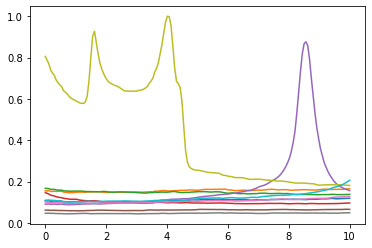

In [70]:
for jj in range(ncurves):
    t = np.linspace(0, time, np.size(reverbLCs[jj], 0))
    plt.plot(t, reverbLCs[jj]/np.max(reverbLCs))

Now we have included some intrinsic variability into the microlensing light curves!

Let's make the variability more important and run a similar test...

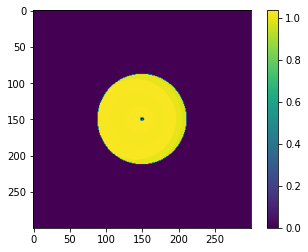

In [71]:
n=23
plt.imshow((hdu[:,:,n]>0.98)*hdu[:,:,n])
plt.colorbar()

In [72]:
steps = 50 # Number of time steps
incang2 = 40 # Needed to calculate time delays
steptimescale = 60*60 # 1 step = 1 light hour
flickering2 = QMF.DampedWalk(np.ones(steps), dampingfactor = 0.01, steppingfactor=0.2)
hdu2, _, _, _= QMF.CreateReverbDisk(sim5disk, steps, incang2, zquasar=zquasar, 
                    steptimescale = steptimescale, mass = 10**m_bh_exp*10**30, 
                    inputsignal = True, illumination = flickering2, sim5 = True)

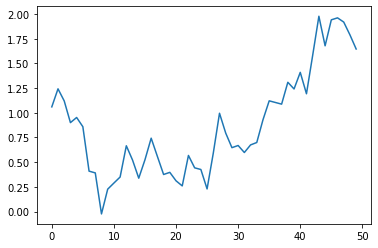

In [73]:
plt.plot(flickering2)

In [74]:
reverbdisk2 = np.zeros([np.size(hdu2, 0), np.size(hdu2, 1), steps])
for jj in range(steps):
    reverbdisk2[:, :, jj] = hdu2[:, :, jj]*sim5disk

In [75]:
reverbsim5LCs, sim5tracks = QMF.TimeDependentLCGenerator(MagMap2d, reverbdisk2, ncurves, 
            velocity, time, zlens = 0.5, zquasar = 2.1, mquasarexponent = 8.0, 
            mlens = 1.0*const.M_sun.to(u.kg), nmapERs = 25, numGRs = 100, diskfov = 0.12, 
            diskposition = 4000, diskres = 300, 
            sim5 = True, rotation=False, verbose=False)

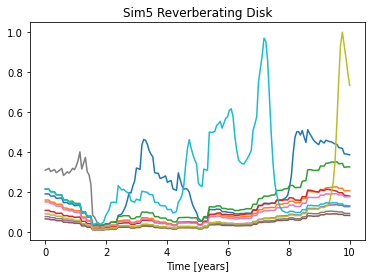

In [76]:
figsim5reverb, axsim5reverb = plt.subplots()
axsim5reverb.set_title("Sim5 Reverberating Disk")
axsim5reverb.set_xlabel("Time [years]")
for jj in range(ncurves):
    t = np.linspace(0, time, np.size(reverbsim5LCs[jj], 0))
    plt.plot(t, reverbsim5LCs[jj]/np.max(reverbsim5LCs))

Let's compare this to the non-reverberating disk case!

In [77]:
sim5nonreverblcs = []
for jj in range(ncurves):
    lc = smooth_convo_sim5(sim5tracks[jj][0], sim5tracks[jj][1], grid=False)
    sim5nonreverblcs.append(lc)


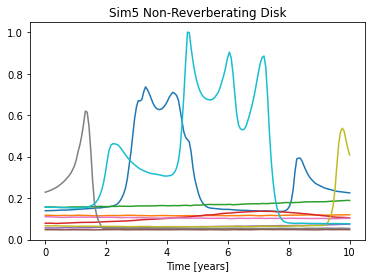

In [78]:
figsim5noreverb, axsim5noreverb = plt.subplots()
axsim5noreverb.set_title("Sim5 Non-Reverberating Disk")
axsim5noreverb.set_xlabel("Time [years]")
for jj in range(ncurves):
    t = np.linspace(0, time, np.size(sim5nonreverblcs[jj], 0))
    plt.plot(t, sim5nonreverblcs[jj]/np.max(sim5nonreverblcs))

High magnification events are still dominant, but in light curves without these high magnifications, the intrinsic variability can appear very prominently!

We can easily see the magnification tracks on the convolution as shown below.

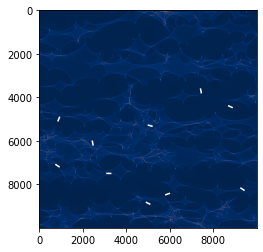

In [79]:
plt.imshow(convo_sim5.real, cmap='cividis')
for jj in range(ncurves):
    plt.plot((sim5tracks[jj][0][0], sim5tracks[jj][0][-1]), (sim5tracks[jj][1][0], sim5tracks[jj][1][-1]), c='white')

In [81]:
print(np.shape(reverbdisk))

(300, 300, 50)


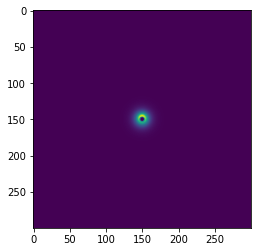

In [90]:
plt.imshow(reverbdisk[:,:, 0])

In [91]:
print(np.shape(reverbdisk[:, :, 0]))

(300, 300)


In [92]:
snap1 = reverbdisk[:, :, 0]
snap2 = reverbdisk[:, :, 1]
snap3 = reverbdisk[:, :, 2]
snap4 = reverbdisk[:, :, 3]
snap5 = reverbdisk[:, :, 4]



In [94]:
f1 =  fits.PrimaryHDU(snap1)
f1.writeto('Snapshot1.fits')
f2 =  fits.PrimaryHDU(snap2)
f2.writeto('Snapshot2.fits')
f3 =  fits.PrimaryHDU(snap3)
f3.writeto('Snapshot3.fits')
f4 =  fits.PrimaryHDU(snap4)
f4.writeto('Snapshot4.fits')
f5 =  fits.PrimaryHDU(snap5)
f5.writeto('Snapshot5.fits')


0.0036539882924314774


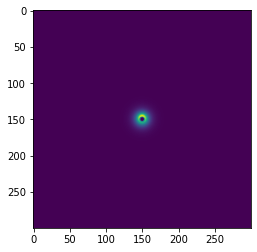

In [100]:
with fits.open('/Users/henrybest/PythonStuff/Code/Snapshot4.fits') as f:
    loadedimage = f[0].data
plt.imshow(loadedimage)
print(np.max(loadedimage))

In [305]:
ranlabel = 8.478652973
q = str(ranlabel)[:4]
print(q)

8.47


In [312]:
print(QMF.CalcEinsteinRadius(0.5, 2.0)*QMF.AngDiameterDistance(2.0)*0.15)

78585356543250.55 m


In [313]:
print((QMF.CalcEinsteinRadius(0.5, 2.0)*QMF.AngDiameterDistance(2.0)*0.15/(100*u.km/u.s)).to(u.day))

9095.527377691036 d


In [314]:
print((QMF.CalcEinsteinRadius(0.5, 2.0)*QMF.AngDiameterDistance(2.0)*0.15/(300*u.km/u.s)).to(u.day))

3031.8424592303454 d


In [315]:
print((QMF.CalcEinsteinRadius(0.5, 2.0)*QMF.AngDiameterDistance(2.0)*0.15/(1000*u.km/u.s)).to(u.day))

909.5527377691036 d


In [316]:
print(9090/1500)

6.06


In [317]:
print(3030/1500)

2.02


In [318]:
print(909/1500)

0.606


In [339]:
with fits.open('../Sim5ThinDisk8.423Msun0.215Spin6.959Inc2.0rsUGRIZY.fits') as f:
    disk1 = f[0].data
    mass1 = f[0].header['mass']
    spin1 = f[0].header['spin']
    inc_ang1 = f[0].header['inc_ang']
with fits.open('../Sim5ThinDisk9.920Msun0.237Spin36.10Inc2.0rsUGRIZY.fits') as f:
    disk2 = f[0].data
    mass2 = f[0].header['mass']
    spin2 = f[0].header['spin']
    inc_ang2 = f[0].header['inc_ang']

8.423378471696957 0.215735745717937 6.959497726566669


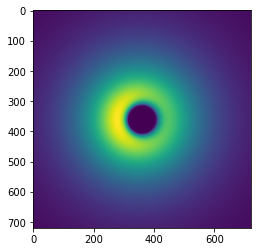

In [340]:
plt.imshow(disk1[:, :, 0])
print(mass1, spin1, inc_ang1)

9.920876124022412 0.2377286180882698 36.10909817374056


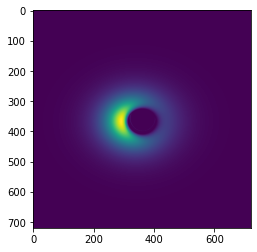

In [341]:
plt.imshow(disk2[:, :, 0])
print(mass2, spin2, inc_ang2)

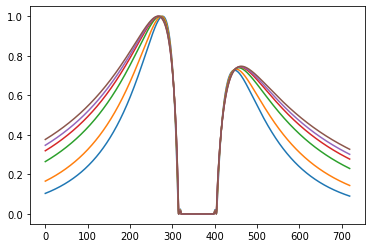

In [342]:
plt.plot(disk1[360, :, 0]/max(disk1[360, :, 0]))
plt.plot(disk1[360, :, 1]/max(disk1[360, :, 1]))
plt.plot(disk1[360, :, 2]/max(disk1[360, :, 2]))
plt.plot(disk1[360, :, 3]/max(disk1[360, :, 3]))
plt.plot(disk1[360, :, 4]/max(disk1[360, :, 4]))
plt.plot(disk1[360, :, 5]/max(disk1[360, :, 5]))



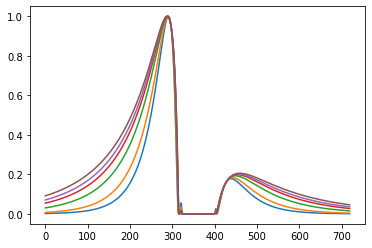

In [343]:
plt.plot(disk2[360, :, 0]/max(disk2[360, :, 0]))
plt.plot(disk2[360, :, 1]/max(disk2[360, :, 1]))
plt.plot(disk2[360, :, 2]/max(disk2[360, :, 2]))
plt.plot(disk2[360, :, 3]/max(disk2[360, :, 3]))
plt.plot(disk2[360, :, 4]/max(disk2[360, :, 4]))
plt.plot(disk2[360, :, 5]/max(disk2[360, :, 5]))



In [344]:
print(np.argmax(disk1[360, 420:, 0]))
print(np.argmax(disk1[360, 420:, 1]))
print(np.argmax(disk1[360, 420:, 2]))
print(np.argmax(disk1[360, 420:, 3]))
print(np.argmax(disk1[360, 420:, 4]))
print(np.argmax(disk1[360, 420:, 5]))


27
31
36
40
41
43


In [345]:
print(np.argmax(disk2[360, 420:, 0]))
print(np.argmax(disk2[360, 420:, 1]))
print(np.argmax(disk2[360, 420:, 2]))
print(np.argmax(disk2[360, 420:, 3]))
print(np.argmax(disk2[360, 420:, 4]))
print(np.argmax(disk2[360, 420:, 5]))



19
22
29
34
37
40


In [346]:
print(np.argmax(disk2[360, :360, 0]))
print(np.argmax(disk2[360, :360, 1]))
print(np.argmax(disk2[360, :360, 2]))
print(np.argmax(disk2[360, :360, 3]))
print(np.argmax(disk2[360, :360, 4]))
print(np.argmax(disk2[360, :360, 5]))



291
290
289
288
288
288


In [347]:
print(np.argmax(disk1[360:, 360, 0]))
print(np.argmax(disk1[360:, 360, 1]))
print(np.argmax(disk1[360:, 360, 2]))
print(np.argmax(disk1[360:, 360, 3]))
print(np.argmax(disk1[360:, 360, 4]))
print(np.argmax(disk1[360:, 360, 5]))



86
89
94
96
98
99


In [349]:
ls ../*.fits

../BrightnessPlot1ER60deg200nm.fits
../BrightnessPlot1ER60deg200nmNOEFFECTS.fits
../NormedTenthThinDiskWithHole.fits
../NormedTenthThinDiskWithHole2e7M.fits
../NormedTenthThinDiskWithHoleMatchedRes.fits
../NormedTenthThinDiskWithoutHole.fits
../NormedTenthThinDiskWithoutHole2e7M.fits
../NormedTenthThinDiskWithoutHoleMatchedRes.fits
../NormedThinDiskWithHole.fits
../NormedThinDiskWithHole2e8M.fits
../NormedThinDiskWithoutHole.fits
../NormedThinDiskWithoutHole2e8M.fits
../NormedThinDiskWithoutHole7Lday.fits
../ReverbDiskgband8.5M45deg.fits
../Sim5ThinDisk8.0Msun0.0Spin10IncBands.fits
../Sim5ThinDisk8.0Msun0.0Spin1IncBands.fits
../Sim5ThinDisk8.0Msun0.0Spin20IncBands.fits
../Sim5ThinDisk8.0Msun0.0Spin30IncBands.fits
../Sim5ThinDisk8.0Msun0.0Spin40IncBands.fits
../Sim5ThinDisk8.0Msun0.0Spin50IncBands.fits
../Sim5ThinDisk8.0Msun0.0Spin60IncBands.fits
../Sim5ThinDisk8.377Msun0.523Spin19.53IncUGRIZY.fits
../Sim5ThinDisk8.423Msun0.215Spin6.959Inc2.0rsUGRIZY.fits
../Sim5ThinDisk9.840Msun0.113Sp

In [2]:
files = glob.glob("../*UGRIZY.fits")

In [3]:
print(files)

['../Sim5ThinDisk9.920Msun0.237Spin36.10Inc2.0rsUGRIZY.fits', '../Sim5ThinDisk8.423Msun0.215Spin6.959Inc2.0rsUGRIZY.fits', '../Sim5ThinDisk9.928Msun0.784Spin86.20Inc2.0rsUGRIZY.fits', '../Sim5ThinDisk8.377Msun0.523Spin19.53IncUGRIZY.fits', '../Sim5ThinDisk9.921Msun0.242Spin38.06Inc2.0rsUGRIZY.fits', '../Sim5ThinDisk9.840Msun0.113Spin77.45IncUGRIZY.fits']


In [47]:
transfer_functions = np.zeros((np.size(files), 800, 5))
index = 0
for file in files:
    with fits.open(file) as f:
        disk = f[0].data
        massexp = f[0].header['mass']
        incang = f[0].header['inc_ang']
    for band in range(5):
        delaymap = QMF.CreateTimeDelayMap(disk[:, :, band], incang, massquasar = 10**massexp * const.M_sun.to(u.kg), sim5 = True)
        transfer_function = np.zeros(800)
        for jj in range(800):
            maskin = delaymap>=jj
            maskout = delaymap<=(jj+1)
            mask = maskin * maskout
            transfer_function[jj] = np.sum((mask * disk[:, :, band]), (0, 1))
            transfer_functions[index, :, band] = (transfer_function)
    index += 1



../Sim5ThinDisk9.921Msun0.242Spin38.06Inc2.0rsUGRIZY.fits


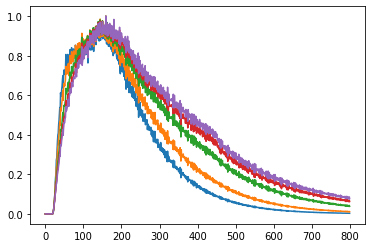

In [59]:
number = 4
for jj in range(5):
    plt.plot(transfer_functions[number, :, jj]/max(transfer_functions[number, :, jj]))
print(files[number])


In [25]:
print(np.shape(transfer_functions))

(6, 400, 5)


In [26]:
print(np.max(transfer_functions))

1.4599381095426386e+18


In [61]:
print(files[1][-54:-5])

Sim5ThinDisk8.423Msun0.215Spin6.959Inc2.0rsUGRIZY


In [62]:
ls

AccDiskProfileTest.py
AnimateWindLine.py
Backups/
CalcVariousERsLSST.py
CalculateHalfLight.py
CalculateRatios.py
CalculateTransferFunctions.py
Classwork/
CompareSim5GyotoDisk.py
ComputeManyImages.py
ComputePowerSpectraDRW.py
ConvertDataFile.py
ConvertMagMapToFits.py
ConvertManyDataFiles.py
ConvertMappingFile copy.py
ConvertMappingFile.py
Convolve.py
CreateDataFile.py
CreateExampleCrossingMap.py
CreateFaceOnDisk.py
CreateFilledInISCOCurve.py
CreateGYOTOMapping copy.py
CreateGYOTOMapping.py
CreateGYOTOop copy.py
CreateGYOTOop.py
CreateManyDataFiles.py
CreateManyLSSTCurves.py
CreateMassTest.py
CreateReverbOnlyLC.py
CreateReverberatingDisk.py
CreateReverberatingDiskVariousOrientations.py
CreateWindModel.py
CreateWindModel2.py
Examples.ipynb
FinalTime.py
FirstPaperScripts/
InpaintTest.py
KerrRWI.py
LensBLR.py
LensManyImages.py
LensMovingDisk.py
LensSim5Disk.py
MakeCalculations.py
MakeConvolutions.py
MakeNoiseTest.py
MicrolensReverbDisk.py
ModelExpandingFlare.py
PlotDiskImages2.py
PlotLightC

In [63]:
tffiles = glob.glob('../UGRIZYTransferFunctions/*')

In [64]:
print(len(tffiles))

1000


In [66]:
transferfunctions = np.zeros((1000, 1000, 6))
masses = np.zeros((1000))
incangs = np.zeros((1000))
spins = np.zeros((1000))

In [68]:
for jj in range(len(tffiles)):
    with fits.open(tffiles[jj]) as f:
        transferfunctions[jj, :, :] = f[0].data
        masses[jj] = f[0].header['mass']
        incangs[jj] = f[0].header['inc_ang']
        spins[jj] = f[0].header['spin']
        
        

curve number 840
mass = 8.758810831512776
inclination angle = 74.88605483040057
spin = 0.8941018083639867


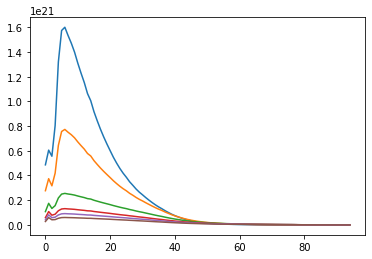

In [208]:
curve = np.random.randint(1000)
peak = np.argmax(transferfunctions[curve, :, 5])
endx = np.argmin(transferfunctions[curve, peak:, 5]) # After this point, everything is zero
length = peak + endx
for xx in range(6):
    if length < 999:
        plt.plot(transferfunctions[curve, :length+1, xx])# / np.max(transferfunctions[curve, :length, xx]))
    else:
        plt.plot(transferfunctions[curve, :length, xx])
print('curve number '+str(curve))
print('mass = '+str(masses[curve]))
print('inclination angle = '+str(incangs[curve]))
print('spin = '+str(spins[curve]))

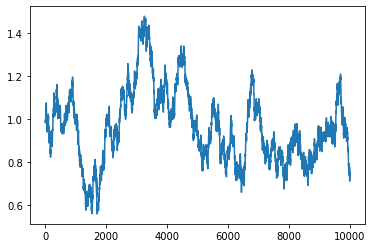

In [174]:
testsignal = QMF.DampedWalk(np.ones(10000), dampingfactor = 0.002)
plt.plot(testsignal)

curve number 943


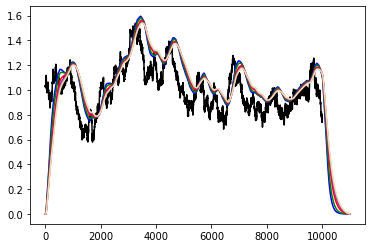

In [211]:
curve = np.random.randint(1000)
newsignalU = signal.convolve(testsignal, transferfunctions[curve, :, 0])#, mode='same')
newsignalG = signal.convolve(testsignal, transferfunctions[curve, :, 1])#, mode='same')
newsignalR = signal.convolve(testsignal, transferfunctions[curve, :, 2])#, mode='same')
newsignalI = signal.convolve(testsignal, transferfunctions[curve, :, 3])#, mode='same')
newsignalZ = signal.convolve(testsignal, transferfunctions[curve, :, 4])#, mode='same')
newsignalY = signal.convolve(testsignal, transferfunctions[curve, :, 5])#, mode='same')

fig, ax = plt.subplots()

ax.plot(testsignal/np.average(testsignal), color='black')
ax.plot(newsignalU/np.average(newsignalU), color='blue')
ax.plot(newsignalG/np.average(newsignalG), color='green')
ax.plot(newsignalR/np.average(newsignalR), color='r')
ax.plot(newsignalI/np.average(newsignalI), color='m')
ax.plot(newsignalZ/np.average(newsignalZ), color='grey')
ax.plot(newsignalY/np.average(newsignalY), color='wheat')



print('curve number '+str(curve))
plt.show()


In [177]:
tfs = fits.PrimaryHDU(transferfunctions)
masshdu = fits.ImageHDU(masses)
spinhdu = fits.ImageHDU(spins)
incanghdu = fits.ImageHDU(incangs)

hdul = fits.HDUList([tfs, masshdu, spinhdu, incanghdu])
hdul.writeto('TransferFunctionData.fits')

In [178]:
ls *.fits

Snapshot1.fits             Snapshot4.fits
Snapshot2.fits             Snapshot5.fits
Snapshot3.fits             TransferFunctionData.fits


In [183]:
with fits.open('TransferFunctionData.fits') as f:
    print(np.shape(f[3]))

(1000,)


In [23]:
 # Streamline Parameters
zmax = (5 + random.normal()) * 10**14 * u.m #Max height of the BELR
theta_in = 10+10*random.uniform() #Degrees, inner streamline bound
theta_out = 40+10*random.normal() #Degrees, outer streamline bound
belrfunction = 2 #A switch statement. 1 = power law, 2 = gaussian, 3 = tophat
r0 = zmax/2 #Central location of emission region if gaussian, or start position if tophat. Implicit units m
sigma = zmax/4 #Width of emitting region. Implicit units m
r_launch_in = 1e13 * u.m #Inner streamline launch position
r_launch_out = 3e13 * u.m #Outer streamline launch position
zslices = 100 # Number of slices to create in the z-direction
maxvel = 1e7 * u.m/u.s # Maximum poloidal velocity accelerated to. Implicit units m/s.
v_scaleheight = 1e14 * u.m # Scale Distance for velocity acceleration. Implicit units m.
v_alpha = 1 # Acceleration parameter
mass = random.uniform(7.0,10.0)
bh_mass = 10**mass
inc_angles = random.uniform(1.0,89.0)
bh_incl = inc_angles

if theta_out <= theta_in + 5:
    theta_out = theta_in + 5

SLin = QMF.CreateWindLine(r_launch_in, theta_in, zmax, zslices, v_scaleheight, 
                          maxvel = maxvel, alpha=v_alpha) #Inner Streamline
SLout = QMF.CreateWindLine(r_launch_out, theta_out, zmax, zslices, v_scaleheight, 
                               maxvel = maxvel, alpha=v_alpha) #Outer Sreamline

BELR, rlen, zlen, philen, rmin = QMF.CreateWindRegion(SLin, SLout, phi_res=80, 
                                function=belrfunction, r0 = r0, sigma = sigma)

xres = 100
velocities = [0] #This is a filler for LoS velocities. Only implimented in reverberation calculation..
screen, fov_BELR = QMF. ProjectWind(BELR, rlen, zlen, philen, rmin, bh_incl, xres, SLin, SLout, 
                        velocities, geounits = 4000, mass = bh_mass * const.M_sun.to(u.kg))



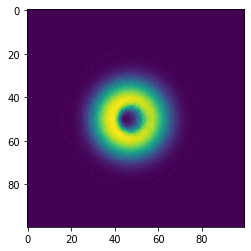

In [24]:
plt.imshow(screen)

In [25]:
blrtf = QMF.CreateBLRTransferFunction(BELR, rlen, zlen, philen, bh_incl, xres, SLin, SLout, 
                                      mass = bh_mass, units = 'days', return_grid = False)

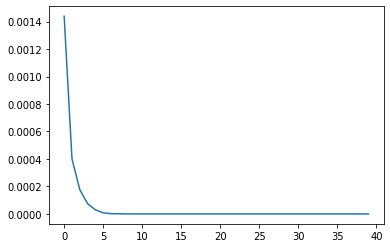

In [26]:
plt.plot(blrtf)

In [43]:
blrtfgrid = QMF.CreateBLRTransferFunction(BELR, rlen, zlen, philen, 20, xres, SLin, SLout, 
                                      mass = bh_mass, units = 'days', return_grid = True)

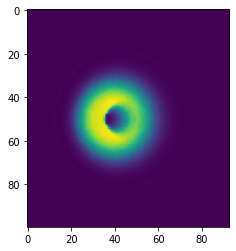

In [48]:
plt.imshow(np.sum(blrtfgrid, -1))

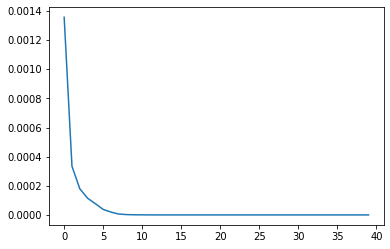

In [50]:
newtf = np.sum(blrtfgrid, (0, 1))
plt.plot(newtf)